In [4]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
from astra.torch.models import EfficientNet,ResNetClassifier, MLP, MLPClassifier, EfficientNetClassifier
from astra.torch.utils import count_params
print(count_params(EfficientNetClassifier()))
print(count_params(ResNetClassifier()))

{'total_params': 4664446, 'trainable_params': 4664446, 'non_trainable_params': 0}
{'total_params': 11440194, 'trainable_params': 11440194, 'non_trainable_params': 0}


In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn as nn
import copy
import time
import os
import argparse
from torch.utils.data import Subset
import csv
device = torch.device('cuda')
from ResNet import *
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import ConfusionMatrixDisplay

### transforms for downstream tasks

In [4]:
# transform_test = transforms.Compose([
#         transforms.Resize(224),
#         # transforms.ToTensor(),
#         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#     ])

# transform_eval = transforms.Compose([
#         transforms.RandomResizedCrop((224,224), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
#         transforms.RandomHorizontalFlip(p=0.5),
#         transforms.Resize(224),
#         # transforms.ToTensor(),
#         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#     ])


In [24]:
loaded_data = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/test_data.pt")
loaded_data1 = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/data.pt")
images= loaded_data1['images']
labels = loaded_data1['labels']
images = images / 255
images = (images - images.mean(dim=(0, 2, 3), keepdim=True)) / images.std(dim=(0, 2, 3), keepdim=True)
images1 = loaded_data['images']
labels1 = loaded_data['labels']
images1 = images1 / 255
images1 = (images1 - images1.mean(dim=(0, 2, 3), keepdim=True)) / images1.std(dim=(0, 2, 3), keepdim=True)
print(images1.shape)
print(labels1.shape)
print(images.shape)
print(labels.shape)
train_images = images[:2250]
train_labels = labels[:2250]
test_images = images1
test_labels = labels1

torch.Size([10025, 3, 224, 224])
torch.Size([10025])
torch.Size([25500, 3, 224, 224])
torch.Size([25500])


In [1]:
train_labels_count = (train_labels == 1).sum()
test_labels_count = (test_labels == 1).sum()

print("Number of train labels with value 1:", train_labels_count)
print("Number of test labels with value 1:", test_labels_count)
# train_images=transform_eval(train_images)
# test_images=transform_test(test_images)

NameError: name 'train_labels' is not defined

### Data preporcessing for how much percentage of the data is used for finetune

In [27]:
print(train_images.shape)
print(test_images.shape)
train_set=torch.utils.data.TensorDataset(train_images,train_labels)
test_set=torch.utils.data.TensorDataset(test_images,test_labels)
train_loader=torch.utils.data.DataLoader(train_set,batch_size=512,shuffle=True,num_workers=8)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=512,shuffle=False,num_workers=8)

torch.Size([2250, 3, 224, 224])
torch.Size([10025, 3, 224, 224])


In [4]:
# class Identity(nn.Module):
#     def __init__(self):
#         super(Identity, self).__init__()

#     def forward(self, x):
#         return x
# class SimCLR_model(nn.Module):
#     def __init__(self, base_encoder, projection_dim, n_features):
#         super(SimCLR_model, self).__init__()

#         self.base_encoder = base_encoder
#         self.n_features = n_features
#         self.base_encoder.fc=nn.Linear(n_features, n_features)

#         self.base_encoder.linear = Identity()
#         self.projectionHead = nn.Sequential(
#             nn.Linear(self.n_features, self.n_features, bias=False),
#             nn.BatchNorm1d(self.n_features),
#             nn.ReLU(), #non-linearity
#             nn.Linear(self.n_features, projection_dim, bias=False),
#             nn.BatchNorm1d(projection_dim),
#         )

#     def forward(self, x_i, x_j):
#         h_i = self.base_encoder(x_i)
#         h_j = self.base_encoder(x_j)
        
#         z_i = self.projectionHead(h_i)
#         z_j = self.projectionHead(h_j)
        
#         return h_i, h_j, z_i, z_j

In [9]:
base_encoder = torchvision.models.resnet50(pretrained=False)

/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [14]:
base_encoder = torchvision.models.resnet50(pretrained=False)
n_features= base_encoder.fc.in_features
print(n_features)
base_encoder.fc=nn.Linear(n_features, n_features)
base_encoder.linear=nn.Linear(n_features, 2)

2048


In [34]:
model=base_encoder
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
# base_encoder
optimizer = torch.optim.Adam(base_encoder.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
model.to(device)
model.train()
train_loss=0.0
correct=0.0
total=0.0
epochs=50
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
        _,predicted=output.max(1)
        total+=labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print('Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
        % (train_loss/(i+1), 100.*correct/total, correct, total))

            

Train Loss: 0.008 | Train Acc: 99.867% (2247/2250)
Train Loss: 0.021 | Train Acc: 99.756% (4489/4500)
Train Loss: 0.029 | Train Acc: 99.719% (6731/6750)
Train Loss: 0.038 | Train Acc: 99.700% (8973/9000)
Train Loss: 0.045 | Train Acc: 99.698% (11216/11250)
Train Loss: 0.052 | Train Acc: 99.726% (13463/13500)
Train Loss: 0.057 | Train Acc: 99.746% (15710/15750)
Train Loss: 0.063 | Train Acc: 99.744% (17954/18000)
Train Loss: 0.067 | Train Acc: 99.758% (20201/20250)
Train Loss: 0.072 | Train Acc: 99.764% (22447/22500)
Train Loss: 0.077 | Train Acc: 99.774% (24694/24750)
Train Loss: 0.085 | Train Acc: 99.767% (26937/27000)
Train Loss: 0.089 | Train Acc: 99.774% (29184/29250)
Train Loss: 0.091 | Train Acc: 99.787% (31433/31500)
Train Loss: 0.095 | Train Acc: 99.799% (33682/33750)
Train Loss: 0.102 | Train Acc: 99.806% (35930/36000)
Train Loss: 0.113 | Train Acc: 99.796% (38172/38250)


Exception ignored in: <function _releaseLock at 0x7efe1d82fe20>
Traceback (most recent call last):
  File "/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


Train Loss: 0.125 | Train Acc: 99.788% (40414/40500)
Train Loss: 0.130 | Train Acc: 99.794% (42662/42750)
Train Loss: 0.135 | Train Acc: 99.796% (44908/45000)
Train Loss: 0.138 | Train Acc: 99.801% (47156/47250)
Train Loss: 0.143 | Train Acc: 99.802% (49402/49500)
Train Loss: 0.156 | Train Acc: 99.803% (51648/51750)
Train Loss: 0.165 | Train Acc: 99.800% (53892/54000)
Train Loss: 0.174 | Train Acc: 99.799% (56137/56250)


In [32]:
percent = "50%"
ssl = "SimCLR"
with torch.no_grad():    
    base_encoder.eval()
    correct = 0
    total = 0
    y_pred = []
    y_test = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = base_encoder(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            y_pred.extend(predicted.cpu().numpy())
            y_test.extend(targets.cpu().numpy())
    
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    
    print('Test Acc: %.3f%% (%d/%d)' % (100.*correct/total, correct, total))
    print(len(y_pred), len(y_test))
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # If needed, class-specific metrics
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    class_precision = precision_score(y_test, y_pred, average=None)
    class_recall = recall_score(y_test, y_pred, average=None)
    class_f1 = f1_score(y_test, y_pred, average=None)

    print("Class-specific Accuracy:", class_accuracy)
    print("Class-specific Precision:", class_precision)
    print("Class-specific Recall:", class_recall)
    print("Class-specific F1 Score:", class_f1)



Test Acc: 89.476% (8970/10025)
10025 10025
Accuracy:  0.8947630922693267
Precision:  0.43010752688172044
Recall:  0.03838771593090211
F1 Score:  0.07048458149779735
Confusion Matrix:
[[8930   53]
 [1002   40]]
Class-specific Accuracy: [0.99409997 0.03838772]
Class-specific Precision: [0.89911398 0.43010753]
Class-specific Recall: [0.99409997 0.03838772]
Class-specific F1 Score: [0.94422416 0.07048458]


In [22]:
# base_encoder = ResNet50()
# projection_dim=224
# n_features= base_encoder.fc.in_features
# net= SimCLR_model(base_encoder, projection_dim, n_features)
# net
# # net
# # print(base_encoder.fc.weight) #weights of the linear layer before loading the model with SimCLR
# path_paramsend = "/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/Saved_model/paramsend_bs_restart_r_bk_DB.pt"
# checkpoint = torch.load(path_paramsend, map_location=torch.device('cpu'))
# loss= checkpoint['loss']
# epoch = checkpoint['epoch']
# start_epoch=0
# net.load_state_dict(checkpoint['net'])
# # epoch

In [21]:
# checkpoint['net']

In [10]:
classes = ('positive', 'negetive')
net_eval= base_encoder
n_features= base_encoder.fc.in_features
print(n_features)
net_eval.linear=nn.Linear(n_features, len(classes)) 
print(net_eval.linear)
optimizer= torch.optim.SGD(net_eval.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
net_eval.to(device)
print(net_eval.fc.weight) #weights of the linear layer after loading the model with SimCLR

2048
Linear(in_features=2048, out_features=2, bias=True)
Parameter containing:
tensor([[-0.0108,  0.0187,  0.0143,  ..., -0.0158,  0.0152, -0.0151],
        [ 0.0046, -0.0010, -0.0186,  ...,  0.0019, -0.0166, -0.0045],
        [-0.0212, -0.0076, -0.0166,  ...,  0.0144, -0.0198,  0.0135],
        ...,
        [-0.0162, -0.0132, -0.0034,  ...,  0.0152,  0.0018, -0.0049],
        [-0.0191,  0.0186,  0.0180,  ..., -0.0108, -0.0155,  0.0051],
        [ 0.0157, -0.0084, -0.0128,  ...,  0.0134, -0.0103,  0.0146]],
       device='cuda:0', requires_grad=True)


### fine-tune the downstram model  and predict on test data

In [11]:
#train net_eval
net_eval.train()
for epoch in range(start_epoch, start_epoch+100):
    print('Epoch: %d' % epoch)
    net_eval.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net_eval(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    print('Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
        % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


Epoch: 0
Train Loss: 4.015 | Train Acc: 65.333% (1470/2250)
Epoch: 1
Train Loss: 1.639 | Train Acc: 91.467% (2058/2250)
Epoch: 2
Train Loss: 1.640 | Train Acc: 91.467% (2058/2250)
Epoch: 3
Train Loss: 1.189 | Train Acc: 91.467% (2058/2250)
Epoch: 4
Train Loss: 0.728 | Train Acc: 87.733% (1974/2250)
Epoch: 5
Train Loss: 0.361 | Train Acc: 89.200% (2007/2250)
Epoch: 6
Train Loss: 0.332 | Train Acc: 91.467% (2058/2250)
Epoch: 7
Train Loss: 0.318 | Train Acc: 91.467% (2058/2250)
Epoch: 8
Train Loss: 0.306 | Train Acc: 91.467% (2058/2250)
Epoch: 9
Train Loss: 0.277 | Train Acc: 91.467% (2058/2250)
Epoch: 10
Train Loss: 0.256 | Train Acc: 91.511% (2059/2250)
Epoch: 11
Train Loss: 0.255 | Train Acc: 91.689% (2063/2250)
Epoch: 12
Train Loss: 0.252 | Train Acc: 92.089% (2072/2250)
Epoch: 13
Train Loss: 0.228 | Train Acc: 92.222% (2075/2250)
Epoch: 14
Train Loss: 0.233 | Train Acc: 92.667% (2085/2250)
Epoch: 15
Train Loss: 0.220 | Train Acc: 93.067% (2094/2250)
Epoch: 16
Train Loss: 0.224 | Trai

In [12]:
result_dict = {}

In [13]:

def get_metrics(y_pred, y_label):
    acc = accuracy_score(y_label, y_pred)
    f1 = f1_score(y_label, y_pred, average='macro')
    precision = precision_score(y_label, y_pred, average='macro')
    recall = recall_score(y_label, y_pred, average='macro')
    print(f"Accuracy = {acc}")
    print(f"F1 = {f1}")
    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    return acc, f1, precision, recall

def prdict(net_eval, test_loader, percent, ssl, device):
    net_eval.eval()
    correct = 0
    total = 0
    y_pred = []
    y_test = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net_eval(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            y_pred.extend(predicted.cpu().numpy())
            y_test.extend(targets.cpu().numpy())
    print('Test Acc: %.3f%% (%d/%d)' % (100.*correct/total, correct, total))
    acc, f1, precision, recall = get_metrics(y_pred, y_test)
    result_dict[f"{percent} {ssl}"] = {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}
    return y_pred, y_test


In [14]:
print(result_dict)

{}


In [15]:
# import pickle

# # Specify the file path
# file_path = "dictionary.pkl"

# # Open the file in write mode
# with open(file_path, "wb") as file:
#     # Write the dictionary to the file
#     pickle.dump(result_dict, file)


In [16]:
y_pred,ytest=prdict(net_eval, test_loader, "10%", "No_ssl", device,)

Test Acc: 87.591% (8781/10025)
Accuracy = 0.8759102244389028
F1 = 0.6437233301725496
Precision = 0.6550537197960677
Recall = 0.6346764404420976


In [17]:
print(result_dict)

{'10% No_ssl': {'accuracy': 0.8759102244389028, 'f1': 0.6437233301725496, 'precision': 0.6550537197960677, 'recall': 0.6346764404420976}}


In [18]:
import pickle

file_path = "dictionary10_nossl.pkl"

# Open the file in write mode
with open(file_path, "wb") as file:
    # Write the dictionary to the file
    pickle.dump(result_dict, file)

In [19]:
# # Load the dictionaries from the files
with open("dictionary10_nossl.pkl", "rb") as file1, open("merged_dictionary.pkl", "rb") as file2:
    dict1 = pickle.load(file1)
    dict2 = pickle.load(file2)

# Merge the dictionaries
merged_dict = {**dict1, **dict2}

# Save the merged dictionary to a file
with open("merged_dictionary.pkl", "wb") as file:
    pickle.dump(merged_dict, file)

In [20]:
# Load the merged dictionary from the file
with open("merged_dictionary.pkl", "rb") as file:
    merged_dict = pickle.load(file)

# Print the merged dictionary
print(merged_dict)

{'10% No_ssl': {'accuracy': 0.8759102244389028, 'f1': 0.6437233301725496, 'precision': 0.6550537197960677, 'recall': 0.6346764404420976}, '1% No_ssl': {'accuracy': 0.8960598503740649, 'f1': 0.4725904882154882, 'precision': 0.44802992518703244, 'recall': 0.5}, '1% ssl': {'accuracy': 0.8361097256857856, 'f1': 0.49326175961322305, 'precision': 0.4936997243054168, 'recall': 0.4953925553129466}, '100% No_ssl': {'accuracy': 0.8858852867830423, 'f1': 0.5883355296237898, 'precision': 0.6494528284733744, 'recall': 0.5702518598256506}, '50% No_ssl': {'accuracy': 0.8832917705735661, 'f1': 0.5748131015528688, 'precision': 0.631794956421822, 'recall': 0.5598967809316937}, '30% ssl': {'accuracy': 0.8552618453865337, 'f1': 0.6870296510455187, 'precision': 0.6617655428988737, 'recall': 0.7368364599115882}, '10% ssl': {'accuracy': 0.8633416458852868, 'f1': 0.6054464860268431, 'precision': 0.6146796079125735, 'recall': 0.5983943759838107}, '50% ssl': {'accuracy': 0.9000498753117206, 'f1': 0.653781330134

In [22]:
import pandas as pd

In [23]:
resdf = pd.DataFrame(merged_dict)
resdf

,10% No_ssl,1% No_ssl,1% ssl,100% No_ssl,50% No_ssl,30% ssl,10% ssl,50% ssl,100% ssl
accuracy,0.875910,0.89606,0.836110,0.885885,0.883292,0.855262,0.863342,0.900050,0.913217
f1,0.643723,0.47259,0.493262,0.588336,0.574813,0.687030,0.605446,0.653781,0.696559
precision,0.655054,0.44803,0.493700,0.649453,0.631795,0.661766,0.614680,0.729032,0.797193
recall,0.634676,0.50000,0.495393,0.570252,0.559897,0.736836,0.598394,0.622695,0.654645


In [ ]:
# result_df = pd.DataFrame(result_dict)
# result_df.to_csv('SSL_Result.csv', index=False)

df=pd.read_csv("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/SSL_Experiments/patchfill_experiments/SSL_Result.csv")
df


,Unnamed: 0,Results,100% SSL,100% No_ssl
0,0,accuracy,0.913217,0.885885
1,1,f1,0.696559,0.588336
2,2,precision,0.797193,0.649453
3,3,recall,0.654645,0.570252


In [ ]:
#list to tensor
y_pred = torch.tensor(y_pred)
ytest = torch.tensor(ytest)
def results(y_labels,y_pred,plot_confusion = False):
    y_labels = y_labels.to(device) 
    y_pred = y_pred.to(device)
    print(f"Accuracy = {(y_labels == y_pred).float().mean()}")
    if plot_confusion:
        cm = confusion_matrix(y_labels.cpu(), y_pred.cpu())
        unique_labels = np.unique(y_labels.cpu())
        cm_display = ConfusionMatrixDisplay(cm, display_labels=unique_labels).plot(values_format='d', cmap='Blues')
        plt.show()

Accuracy = 0.8832917809486389


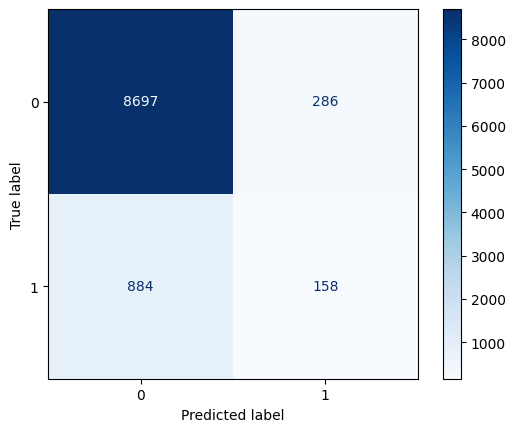

In [ ]:
results(ytest,y_pred,plot_confusion = True)